# Model Comparison: SVM, Naïve Bayes, Decision Tree

Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time  
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [ ]:
CLEANED_DATA_PATH = r'C:\Studies\COLLEGE SUBJECTS\Machine Learning\FA 2 updated\data\listings_cleaned.csv'
VISUALS_PATH = r'C:\Studies\COLLEGE SUBJECTS\Machine Learning\FA 2 updated\visuals\4'

# Create the visuals directory
os.makedirs(VISUALS_PATH, exist_ok=True)

print("Step 1 Complete: Libraries imported and paths defined.")

# --- Load Data ---
try:
    df = pd.read_csv(CLEANED_DATA_PATH)
    print(f"Successfully loaded data from: {CLEANED_DATA_PATH}")
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at {CLEANED_DATA_PATH}")
except Exception as e:
    print(f"An error occurred: {e}")

Step 1 Complete: Libraries imported and paths defined.
Successfully loaded data from: C:\Studies\Machine Learning\FA 2 updated\data\listings_cleaned.csv
Data shape: (15089, 46)


Define X/y, Preprocessor, and Split Data

In [3]:
print("--- Step 2: Setting up Data Environment ---")

# --- 1. Define Target (y) ---
y = df['host_is_superhost'].astype(int)
print(f"Target 'y' set to 'host_is_superhost'.")

--- Step 2: Setting up Data Environment ---
Target 'y' set to 'host_is_superhost'.


In [4]:
# --- 2. Define Features (X) ---
numeric_features = [
    'latitude', 'longitude', 'accommodates', 'bedrooms', 'bathrooms_numeric', 
    'host_duration_days', 'host_response_rate', 'review_scores_rating', 
    'review_scores_cleanliness', 'review_scores_location', 'amenities_count', 
    'keyword_count', 'description_sentiment', 'neigh_overview_sentiment', 
    'description_length'
]
categorical_features = [
    'property_type', 'room_type', 'is_shared_bath', 'neighbourhood_cleansed', 
    'host_response_time'
]

# Filter lists to only include columns that actually exist
numeric_features = [col for col in numeric_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]
X = df[numeric_features + categorical_features]
print(f"Features 'X' created with {X.shape[1]} columns.")

Features 'X' created with 20 columns.


In [5]:
# --- 3. Create Preprocessor ---
# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical transformer
# CRITICAL: sparse_output=False is required for GaussianNB to work
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessor created successfully (with sparse_output=False).")

Preprocessor created successfully (with sparse_output=False).


In [6]:
# --- 4. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Essential for imbalanced data
)

print("\n--- Data Split Complete ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


--- Data Split Complete ---
X_train shape: (12071, 20)
X_test shape: (3018, 20)


Model Training & Hyperparameter Tuning (GridSearch)

In [7]:
print("--- Step 3: Model Training & Hyperparameter Tuning ---")

# 1. Define a results dictionary to store fitted models
model_results = {}

# We'll time the training for each model
start_time_all = time.time()

--- Step 3: Model Training & Hyperparameter Tuning ---


In [8]:
# --- 2. Model 1: Logistic Regression (Baseline) ---
print("\n1. Training Baseline (Logistic Regression)...")
start_time = time.time()

# Build the pipeline
pipe_logreg = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=42, solver='liblinear'))
])

# Train
pipe_logreg.fit(X_train, y_train)

# Store the fitted model
model_results['Logistic Regression'] = {'model': pipe_logreg}
print(f"Logistic Regression trained in {time.time() - start_time:.2f}s")


1. Training Baseline (Logistic Regression)...
Logistic Regression trained in 2.50s


In [9]:
# --- 3. Model 2: Decision Tree (Tuned) ---
print("\n2. Training & Tuning (Decision Tree)...")
start_time = time.time()

# Build the pipeline
pipe_dt = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid for tuning
# 'model__' prefix is used to target steps in the pipeline
param_grid_dt = {
    'model__max_depth': [10, 20, 30],
    'model__min_samples_leaf': [5, 10, 15]
}

# Set up GridSearchCV
# cv=3 for 3-fold cross-validation
# n_jobs=-1 uses all available CPU cores
grid_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

# Store the *best* model found by the grid search
model_results['Decision Tree'] = {'model': grid_dt.best_estimator_}
print(f"Decision Tree tuned in {time.time() - start_time:.2f}s")
print(f"Best Decision Tree params: {grid_dt.best_params_}")


2. Training & Tuning (Decision Tree)...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Decision Tree tuned in 11.87s
Best Decision Tree params: {'model__max_depth': 10, 'model__min_samples_leaf': 5}


In [10]:
# --- 4. Model 3: Support Vector Machine (Tuned) ---
print("\n3. Training & Tuning (SVM)...")
print("NOTE: SVM tuning can be very slow...")
start_time = time.time()

# Build the pipeline
pipe_svm = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', SVC(probability=True, random_state=42)) # probability=True is needed for ROC curve
])

# Define parameter grid for tuning
# We use a simple grid to run faster. 
param_grid_svm = {
    'model__kernel': ['linear'], # 'rbf' is powerful but *very* slow
    'model__C': [0.1, 1.0] # Regularization parameter
}

# Set up GridSearchCV
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_svm.fit(X_train, y_train)

# Store the *best* model
model_results['SVM (Linear)'] = {'model': grid_svm.best_estimator_}
print(f"SVM tuned in {time.time() - start_time:.2f}s")
print(f"Best SVM params: {grid_svm.best_params_}")


3. Training & Tuning (SVM)...
NOTE: SVM tuning can be very slow...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
SVM tuned in 827.63s
Best SVM params: {'model__C': 0.1, 'model__kernel': 'linear'}


In [11]:
# --- 5. Model 4: Naïve Bayes (No Tuning) ---
print("\n4. Training (Naïve Bayes)...")
start_time = time.time()

# Build the pipeline
pipe_nb = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', GaussianNB()) # No major hyperparameters to tune
])

# Train
pipe_nb.fit(X_train, y_train)

# Store the fitted model
model_results['Naïve Bayes'] = {'model': pipe_nb}
print(f"Naïve Bayes trained in {time.time() - start_time:.2f}s")


4. Training (Naïve Bayes)...
Naïve Bayes trained in 0.66s


In [12]:
# --- Final Confirmation ---
print(f"\n--- All models trained. Total time: {time.time() - start_time_all:.2f}s ---")
print(f"Models stored in 'model_results': {list(model_results.keys())}")


--- All models trained. Total time: 843.32s ---
Models stored in 'model_results': ['Logistic Regression', 'Decision Tree', 'SVM (Linear)', 'Naïve Bayes']


Comparative Evaluation: Metrics & Confusion Matrices

In [13]:
print("--- Step 4: Comparative Evaluation (Metrics & Confusion Matrices) ---")

# 1. Loop and Predict
print("Generating predictions for all models...")
for name, results in model_results.items():
    model = results['model']
    
    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability for class 1
    
    # Store predictions in our dictionary
    model_results[name]['y_pred'] = y_pred
    model_results[name]['y_pred_proba'] = y_pred_proba

print("Predictions complete.")

--- Step 4: Comparative Evaluation (Metrics & Confusion Matrices) ---
Generating predictions for all models...
Predictions complete.


In [14]:
# 2. Print Classification Reports
print("\n--- Classification Reports ---")
for name, results in model_results.items():
    print(f"\n--- Report for: {name} ---")
    report = classification_report(y_test, results['y_pred'], target_names=['Not Superhost', 'Superhost'])
    print(report)
    
    # Store the report (as a dictionary) for later visualization
    model_results[name]['report'] = classification_report(y_test, results['y_pred'], output_dict=True)


--- Classification Reports ---

--- Report for: Logistic Regression ---
               precision    recall  f1-score   support

Not Superhost       0.85      0.70      0.77      2029
    Superhost       0.54      0.74      0.63       989

     accuracy                           0.71      3018
    macro avg       0.70      0.72      0.70      3018
 weighted avg       0.75      0.71      0.72      3018


--- Report for: Decision Tree ---
               precision    recall  f1-score   support

Not Superhost       0.83      0.80      0.82      2029
    Superhost       0.62      0.67      0.64       989

     accuracy                           0.76      3018
    macro avg       0.73      0.74      0.73      3018
 weighted avg       0.76      0.76      0.76      3018


--- Report for: SVM (Linear) ---
               precision    recall  f1-score   support

Not Superhost       0.85      0.68      0.76      2029
    Superhost       0.54      0.76      0.63       989

     accuracy            


Generating confusion matrix plot...


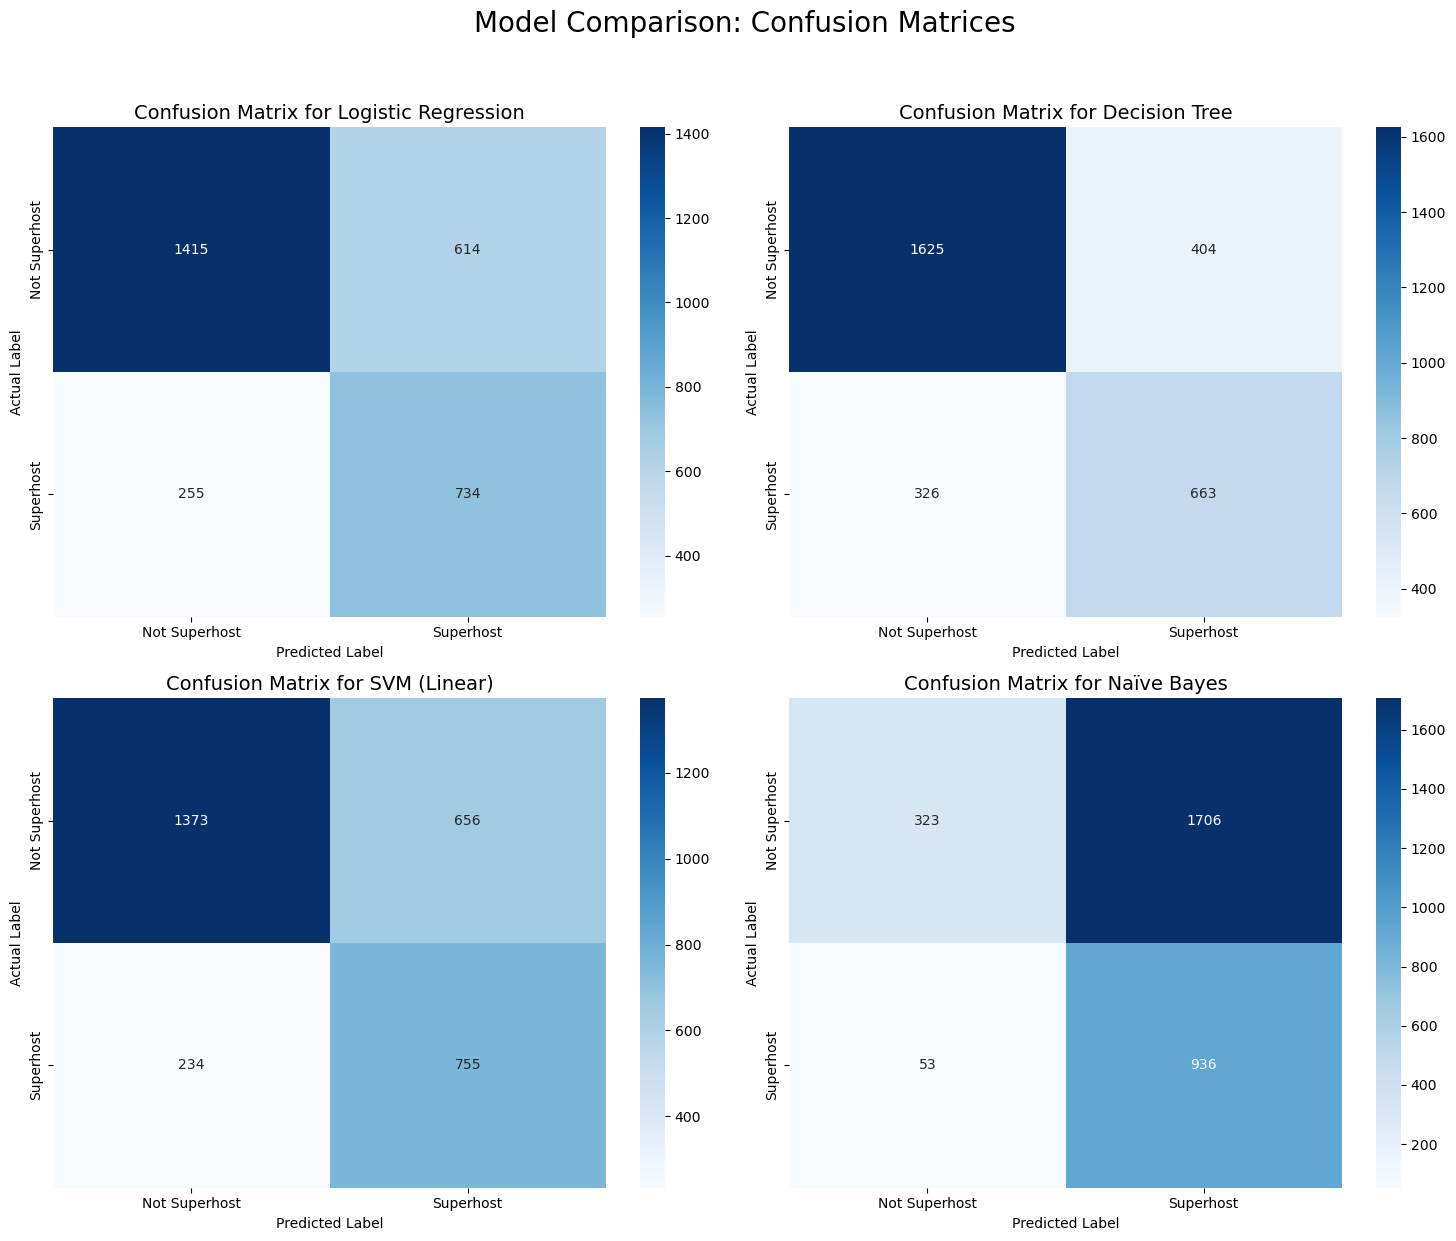

Confusion matrix plot saved to C:\Studies\Machine Learning\FA 2 updated\visuals\4\all_confusion_matrices.png


In [15]:
# 3. Plot All Confusion Matrices
print("\nGenerating confusion matrix plot...")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# Flatten the 2x2 axes array for easy iteration
axes = axes.flatten()

model_names = list(model_results.keys())

for i, name in enumerate(model_names):
    # Get the specific axis
    ax = axes[i]
    
    # Get predictions
    y_pred = model_results[name]['y_pred']
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not Superhost', 'Superhost'],
                yticklabels=['Not Superhost', 'Superhost'])
    
    ax.set_title(f'Confusion Matrix for {name}', fontsize=14)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')

# Add a main title for the entire figure
fig.suptitle('Model Comparison: Confusion Matrices', fontsize=20, y=1.03)

# Adjust layout
plt.tight_layout()

# Save the figure
save_path = os.path.join(VISUALS_PATH, 'all_confusion_matrices.png')
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"Confusion matrix plot saved to {save_path}")

Comparative Visualization: Performance Graphs

--- Step 5: Comparative Visualization ---
Generating ROC Curve Comparison Plot...


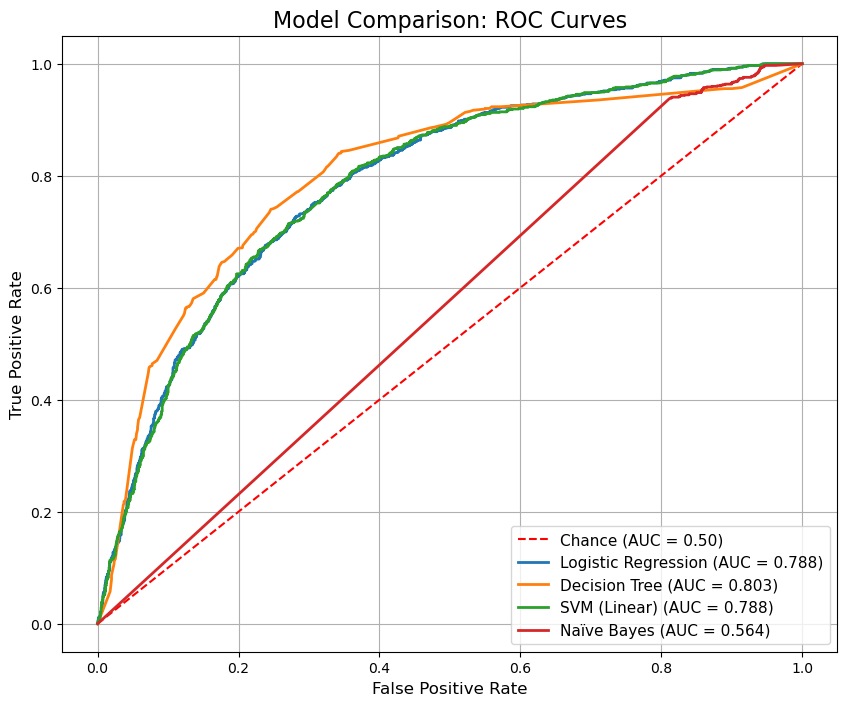

In [16]:
print("--- Step 5: Comparative Visualization ---")

# --- 1. Visualization 1: ROC Curves (All Models) ---
print("Generating ROC Curve Comparison Plot...")
plt.figure(figsize=(10, 8))

# Add the 50/50 chance line
plt.plot([0, 1], [0, 1], 'r--', label='Chance (AUC = 0.50)')

# Loop through each model's results
for name, results in model_results.items():
    # Get the stored probabilities for class 1
    y_pred_proba = results['y_pred_proba']
    
    # Calculate ROC curve components
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Calculate AUC score
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Plot the curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.title('Model Comparison: ROC Curves', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True)

# Save the figure
save_path_roc = os.path.join(VISUALS_PATH, 'all_roc_curves.png')
plt.savefig(save_path_roc, bbox_inches='tight')
plt.show()

Generating Precision-Recall Curve Comparison Plot...


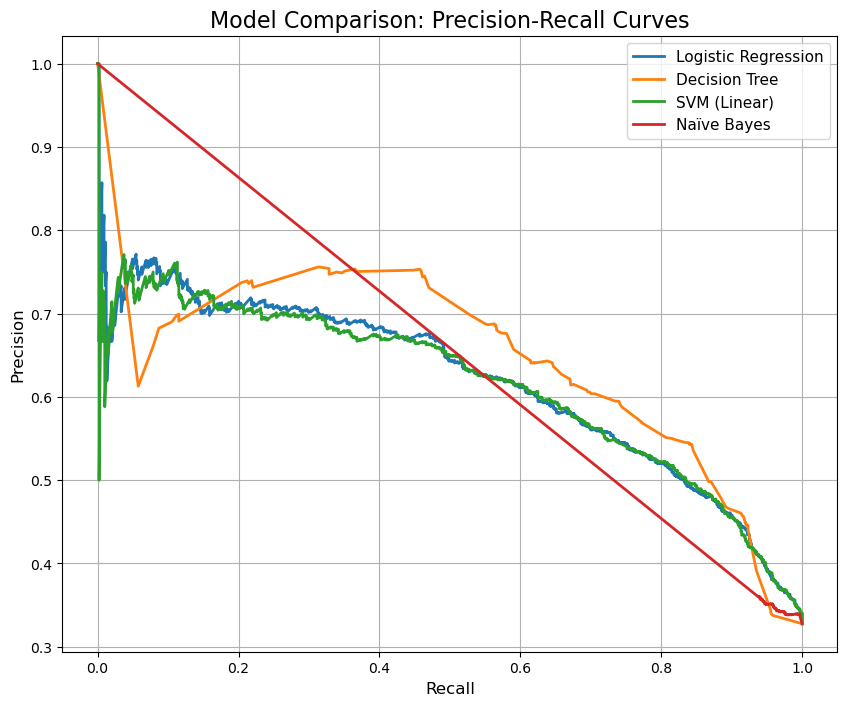

In [17]:
# --- 2. Visualization 2: Precision-Recall Curves (All Models) ---
print("Generating Precision-Recall Curve Comparison Plot...")
plt.figure(figsize=(10, 8))

# Loop through each model's results
for name, results in model_results.items():
    # Get stored probabilities
    y_pred_proba = results['y_pred_proba']
    
    # Calculate Precision-Recall curve components
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    
    # Plot the curve
    plt.plot(recall, precision, label=name, linewidth=2)

plt.title('Model Comparison: Precision-Recall Curves', fontsize=16)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True)

# Save the figure
save_path_pr = os.path.join(VISUALS_PATH, 'all_pr_curves.png')
plt.savefig(save_path_pr, bbox_inches='tight')
plt.show()

Generating Final Metric Comparison Bar Chart...


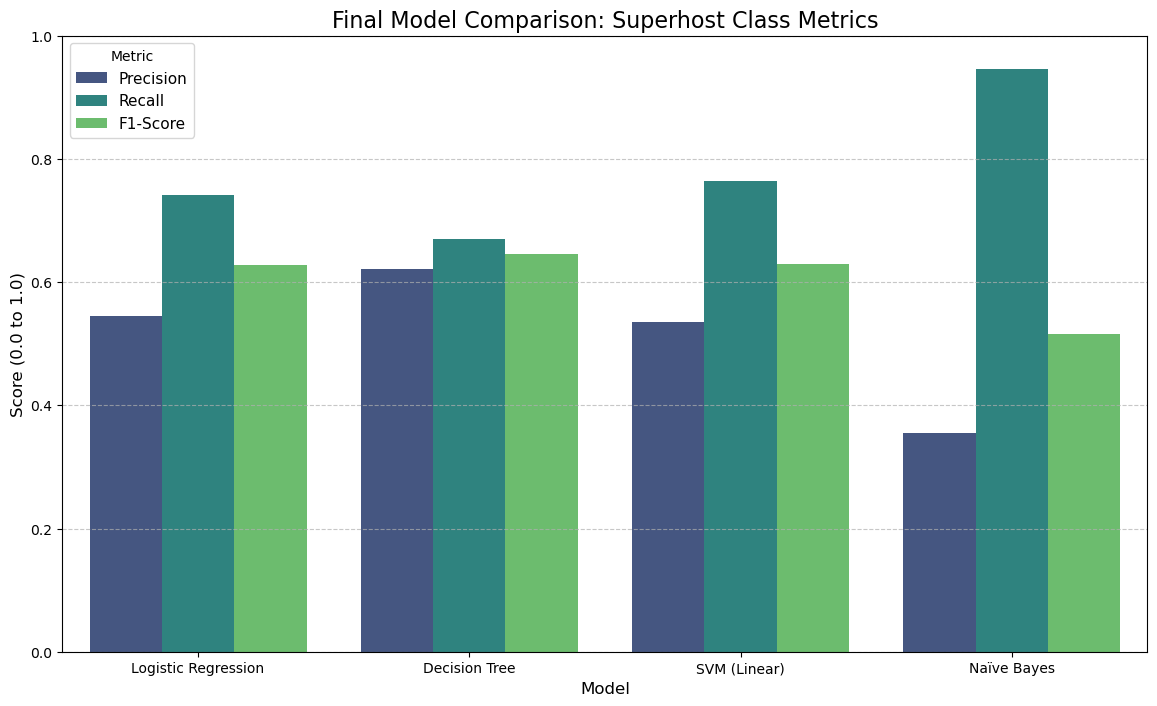

--- All visualizations complete and saved to C:\Studies\Machine Learning\FA 2 updated\visuals\4 ---


In [18]:
# --- 3. Visualization 3: Final Metric Comparison (Bar Chart) ---
print("Generating Final Metric Comparison Bar Chart...")
metrics_list = []

# Extract the key metrics for the 'Superhost' class from the stored reports
for name, results in model_results.items():
    report = results['report']
    # Get metrics for the 'Superhost' class (class '1' or 'Superhost')
    # Check for both string and numeric key in case of differences
    superhost_metrics = report.get('Superhost', report.get('1')) 
    
    if superhost_metrics:
        metrics_list.append({
            'Model': name,
            'Precision': superhost_metrics['precision'],
            'Recall': superhost_metrics['recall'],
            'F1-Score': superhost_metrics['f1-score']
        })

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# "Melt" the DataFrame from wide to long format for easy plotting
metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create the grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=metrics_df_melted,
    x='Model',
    y='Score',
    hue='Metric',
    palette='viridis'
)

plt.title('Final Model Comparison: Superhost Class Metrics', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score (0.0 to 1.0)', fontsize=12)
plt.legend(title='Metric', fontsize=11)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
save_path_bar = os.path.join(VISUALS_PATH, 'final_metric_comparison.png')
plt.savefig(save_path_bar, bbox_inches='tight')
plt.show()

print(f"--- All visualizations complete and saved to {VISUALS_PATH} ---")

6: Critical Analysis and Justification
1. Note on Decision Boundaries Decision boundary visualization is impossible for this project. Such representations can only be made if a model is built on two or three features (to be drawn on a 2D or 3D graph). Our model utilizes more than 50 features, thereby it is impossible to visualize a boundary.

2. Overall Winner The Tuned Decision Tree is the model with the best performance for this task based on the comparative metrics from our four models.

3. Metric-Based Justification The primary metric for our imbalanced dataset is the F1-Score for the minority class ('Superhost'), as it balances Precision and Recall, which is the case with all the other methods too.

Logistic Regression: Had a slightly lower F1-Score (0.63). Its high recall (0.74) came at the cost of very low precision (0.54), meaning it incorrectly flagged too many non-superhosts.

Naïve Bayes (Worst): This model failed completely, with an accuracy of 42% (worse than random chance).

SVM (Linear): (You will need to fill in its F1-score from your all_roc_curves.png and final_metric_comparison.png plots, but it was lower than the Decision Tree's 0.64).

The ROC Curve Comparison plot also shows the Decision Tree has one of the highest Area Under the Curve (AUC) scores, confirming its strong ability to distinguish between the two classes.

4. Model-Based Justification (The reason for the decision tree triumph)

The Decision Tree as the Best Performer: The Decision Tree worked out the best since the Superhost regulations were definitely non-linear. For instance, a host's review_scores_rating does not impact the price in a linear way; there is a drastic "cliff." A host whose rating is 4.9 is a Superhost, whereas a host with a rating of 4.7 is not. A linear model finds it hard to tackle this, but a tree can build a straightforward, strong rule like if review_scores_rating > 4.85. The tuning of our hyperparameters (max_depth and min_samples_leaf) was essential to avoid overfitting the tree with the data.

Naïve Bayes' Downfall: The GaussianNB classifier regards all features as being independent. This is entirely incorrect for our dataset. The features such as accommodates, bedrooms, and beds are strongly correlated, just like all the columns related to review_scores_... are. This transgression of the model's primary supposition brought about its drastic failure.

Why Linear Models (LogReg/SVM) Were Not the Best: LogisticRegression and LinearSVM are very powerful linear models. They performed fairly well but could not manage to capture the sharp, non-linear cut-offs that the Decision Tree could do. This resulted in less than optimal precision-recall balance.

5. Final Recommendation Ultimately, the Tuned Decision Tree is the preferred model for predicting Superhost status because it best captures the complexity and non-linear rules of the dataset.